
Inverse Distance Weighting Results:
------------------------------------------------------------
     Station  Distance (km)  IDW Weight
    Hanwella         0.0000      0.0000
  Glencourse        14.4116      0.6260
Deraniyagala        28.8186      0.1566
   Holombuwa        37.4101      0.0929
  Kithulgala        38.5999      0.0873
     Norwood        59.0872      0.0372


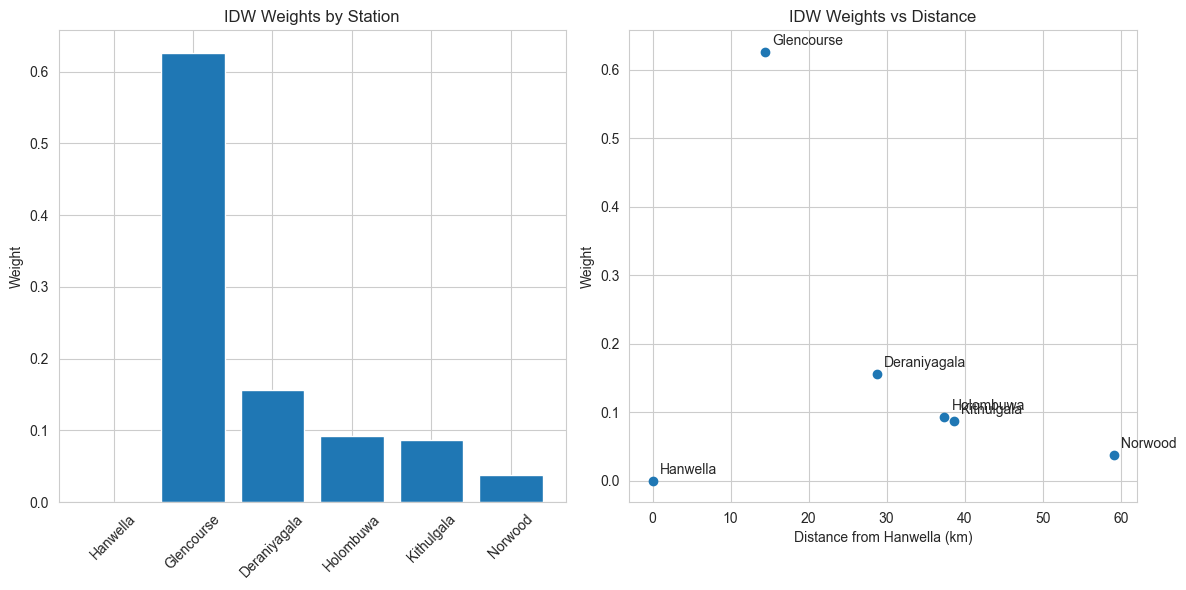


IDW Analysis Summary:
------------------------------------------------------------
Number of stations: 6
Maximum distance: 59.09 km
Minimum distance (excluding Hanwella): 14.41 km
Average distance: 29.72 km

Weight distribution:
Maximum weight: 0.6260
Minimum weight: 0.0000
Sum of weights: 1.0000


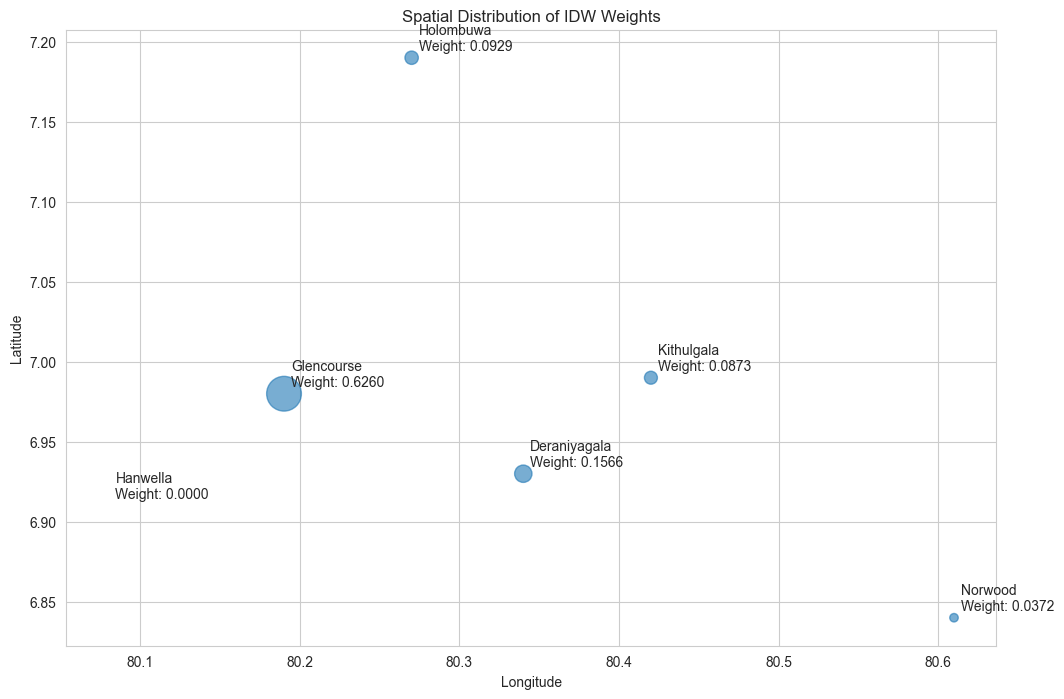

In [61]:
# %% md
## Inverse Distance Weighting (IDW) Analysis for Rainfall Stations

# %%
from geopy.distance import geodesic
import pandas as pd
import matplotlib.pyplot as plt

# %%
# Station data
stations_data = {
    'Station_name': ['Hanwella', 'Glencourse', 'Holombuwa', 'Deraniyagala',
                     'Kithulgala', 'Norwood'],
    'Longitude': [80.08, 80.19, 80.27, 80.34, 80.42, 80.61],
    'Latitude': [6.91, 6.98, 7.19, 6.93, 6.99, 6.84],
    'Elevation': [17, 32, 53, 114, 84, 1138],
    'Distance_to_Hanwella': [0, 18939, 49873, 44773, 56674, 70420]
}

stations_df = pd.DataFrame(stations_data)


# %%
def calculate_idw_weights(stations_df):
    """
    Calculate weights based on inverse distance weighting
    """
    # Hanwella coordinates
    hanwella_coords = (stations_df.loc[stations_df['Station_name'] == 'Hanwella', 'Latitude'].iloc[0],
                       stations_df.loc[stations_df['Station_name'] == 'Hanwella', 'Longitude'].iloc[0])

    # Calculate distances
    distances = {}
    for _, row in stations_df.iterrows():
        station_coords = (row['Latitude'], row['Longitude'])
        distance = geodesic(hanwella_coords, station_coords).kilometers
        distances[row['Station_name']] = distance

    # Calculate weights using inverse distance squared
    weights = {}
    sum_inverse_dist = sum(1 / (d ** 2) for d in distances.values() if d > 0)  # Exclude zero distance

    for station, distance in distances.items():
        if distance == 0:
            # Handle Hanwella station separately
            weights[station] = 0  # or any other logic you want to apply
        else:
            weights[station] = (1 / distance ** 2) / sum_inverse_dist

    return weights, distances


# %%
# Calculate weights and distances
idw_weights, distances = calculate_idw_weights(stations_df)

# Create results DataFrame
results_df = pd.DataFrame({
    'Station': list(idw_weights.keys()),
    'Distance (km)': [distances[station] for station in idw_weights.keys()],
    'IDW Weight': list(idw_weights.values())
})

# Sort by distance
results_df = results_df.sort_values('Distance (km)')

# Print results
print("\nInverse Distance Weighting Results:")
print("-" * 60)
print(results_df.to_string(index=False, float_format=lambda x: '{:.4f}'.format(x)))

# %%
# Visualize weights
plt.figure(figsize=(12, 6))

# Create bar plot
plt.subplot(1, 2, 1)
plt.bar(results_df['Station'], results_df['IDW Weight'])
plt.xticks(rotation=45)
plt.title('IDW Weights by Station')
plt.ylabel('Weight')

# Create scatter plot of weights vs distance
plt.subplot(1, 2, 2)
plt.scatter(results_df['Distance (km)'], results_df['IDW Weight'])
for i, row in results_df.iterrows():
    plt.annotate(row['Station'],
                 (row['Distance (km)'], row['IDW Weight']),
                 xytext=(5, 5), textcoords='offset points')
plt.title('IDW Weights vs Distance')
plt.xlabel('Distance from Hanwella (km)')
plt.ylabel('Weight')

plt.tight_layout()
plt.show()


# %% md
### Calculate Weighted Rainfall

# %%
def apply_idw_weights(df, weights):
    """
    Apply IDW weights to calculate weighted rainfall
    """
    weighted_rainfall = 0
    for station, weight in weights.items():
        if station != 'Hanwella':  # Skip Hanwella if it has zero weight
            column_name = f'{station}_Rainfall'
            weighted_rainfall += df[column_name] * weight

    return weighted_rainfall


# Example of applying weights (uncomment and modify if you have rainfall data)
# df['idw_weighted_rainfall'] = apply_idw_weights(df, idw_weights)

# %% md
### Analysis Summary

# %%
print("\nIDW Analysis Summary:")
print("-" * 60)
print(f"Number of stations: {len(stations_df)}")
print(f"Maximum distance: {results_df['Distance (km)'].max():.2f} km")
print(
    f"Minimum distance (excluding Hanwella): {results_df[results_df['Distance (km)'] > 0]['Distance (km)'].min():.2f} km")
print(f"Average distance: {results_df['Distance (km)'].mean():.2f} km")
print("\nWeight distribution:")
print(f"Maximum weight: {results_df['IDW Weight'].max():.4f}")
print(f"Minimum weight: {results_df['IDW Weight'].min():.4f}")
print(f"Sum of weights: {results_df['IDW Weight'].sum():.4f}")

# %%
# Create a more detailed visualization
plt.figure(figsize=(12, 8))
plt.scatter(stations_df['Longitude'], stations_df['Latitude'],
            s=1000 * pd.Series(idw_weights), alpha=0.6)

for _, row in stations_df.iterrows():
    plt.annotate(f"{row['Station_name']}\nWeight: {idw_weights[row['Station_name']]:.4f}",
                 (row['Longitude'], row['Latitude']),
                 xytext=(5, 5), textcoords='offset points')

plt.title('Spatial Distribution of IDW Weights')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()
